# Imports

In [32]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from helper_metrics import count_missing_district, count_missing_district_total, make_confusion_matrix, calculate_results
import matplotlib.pyplot as plt
from sklearn.experimental    import enable_iterative_imputer
from sklearn.impute          import IterativeImputer
from sklearn.experimental    import enable_hist_gradient_boosting
from sklearn.ensemble        import HistGradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics         import mean_absolute_error, accuracy_score
from tqdm import tqdm


# Load data

In [33]:
df = pd.read_csv("data/semiyearly_chosen_columns_with_crop.csv").iloc[:,2:].drop(["Average of centx","Average of centy"],axis=1)
df

,date,district,total population,Under-Five Population,GAM,MAM,SAM,GAM Prevalence,SAM Prevalence,phase3plus_perc,...,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded,Cowpea,Maize,Sorghum,crop
0,2017-07-01,Adan Yabaal,65262.96000,13052.59200,4819.01697,3733.04131,1085.97565,0.36920,0.08320,0.18000,...,NaN,0.35100,7,False,-0.01820,0,NaN,NaN,NaN,NaN
1,2017-07-01,Luuq,100476.76500,20095.35300,8673.15435,7366.95641,1306.19795,0.43160,0.06500,0.21000,...,NaN,0.39260,7,False,-0.03900,59,14.00000,750.00000,30.00000,264.66667
2,2017-07-01,Buur Hakaba,165968.46000,33193.69200,11909.89669,8198.84192,3711.05477,0.35880,0.11180,0.35000,...,NaN,0.28860,7,False,-0.07020,24,218.00000,30.00000,1.90000,83.30000
3,2017-07-01,Marka,282222.76500,56444.55300,20839.32897,16143.14216,4696.18681,0.36920,0.08320,0.17000,...,NaN,0.35100,7,False,-0.01820,60,330.00000,6.75000,NaN,NaN
4,2017-07-01,Buuhoodle,71317.71000,14263.54200,4858.16241,3652.89311,1205.26930,0.34060,0.08450,0.37000,...,NaN,0.20280,7,False,-0.13780,23,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,2021-07-01,Belet Xaawo,NaN,29314.59999,9820.00000,NaN,1310.00000,0.33499,0.04469,0.15000,...,0.38353,NaN,7,NaN,NaN,15,8.00000,50.00000,NaN,NaN
652,2021-07-01,Jilib,NaN,28586.09073,11560.00000,NaN,2770.00000,0.40439,0.09690,0.11000,...,0.31242,NaN,7,NaN,NaN,51,64.00000,292.00000,NaN,NaN
653,2021-07-01,Caynabo,NaN,16276.00000,3540.00000,NaN,270.00000,0.21750,0.01659,0.17000,...,0.25746,NaN,7,NaN,NaN,29,NaN,NaN,NaN,NaN
654,2021-07-01,Rab Dhuure,NaN,15127.60000,6940.00000,NaN,1560.00000,0.45876,0.10312,0.07000,...,0.50720,NaN,7,NaN,NaN,66,NaN,NaN,14.00000,NaN


# Create train and test sets
X does not need to drop nan values as HGBR can handle nan inputs

In [34]:
y = df.next_prevalence.dropna()
X = df.select_dtypes(exclude=["object", "category"]).iloc[:len(y)].drop(["MAM","next_prevalence","increase_numeric","GAM Prevalence", "Under-Five Population"], axis=1)

In [35]:
X

,total population,GAM,SAM,SAM Prevalence,phase3plus_perc,rainfall,ndvi_score,Price of water,Total alarms,n_conflict_total,prevalence_6lag,month,district_encoded,Cowpea,Maize,Sorghum,crop
0,65262.96000,4819.01697,1085.97565,0.08320,0.18000,19.15667,0.21500,15.00000,2.16667,NaN,NaN,7,0,NaN,NaN,NaN,NaN
1,100476.76500,8673.15435,1306.19795,0.06500,0.21000,24.24000,0.19333,15.00000,7.83333,1.50000,NaN,7,59,14.00000,750.00000,30.00000,264.66667
2,165968.46000,11909.89669,3711.05477,0.11180,0.35000,34.94500,0.34833,52.50000,6.16667,4.66667,NaN,7,24,218.00000,30.00000,1.90000,83.30000
3,282222.76500,20839.32897,4696.18681,0.08320,0.17000,23.56500,0.29833,36.50000,11.83333,11.83333,NaN,7,60,330.00000,6.75000,NaN,NaN
4,71317.71000,4858.16241,1205.26930,0.08450,0.37000,19.54000,0.21333,NaN,2.33333,2.50000,NaN,7,23,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,377653.00000,27985.00000,5945.00000,0.07871,0.22000,19.93833,0.47833,47.91667,6.33333,10.83333,0.36193,1,53,66.00000,406.00000,NaN,NaN
578,72825.00000,2700.00000,520.00000,0.03570,0.15000,16.05833,0.13500,5.00000,0.83333,1.00000,0.24779,1,78,NaN,NaN,NaN,NaN
579,64346.00000,4555.00000,690.00000,0.05361,0.23000,8.12000,0.14833,NaN,0.16667,NaN,0.39980,1,64,NaN,NaN,NaN,NaN
580,51766.00000,3720.00000,595.00000,0.05746,0.16000,18.48000,0.23167,31.66667,3.66667,1.00000,0.47291,1,28,NaN,NaN,NaN,NaN


# Subsets

In [36]:
# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l: object) -> object:
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

# Cross Validation Training

In [37]:
74*5

370

In [38]:
df[:368]

,date,district,total population,Under-Five Population,GAM,MAM,SAM,GAM Prevalence,SAM Prevalence,phase3plus_perc,...,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded,Cowpea,Maize,Sorghum,crop
0,2017-07-01,Adan Yabaal,65262.96000,13052.59200,4819.01697,3733.04131,1085.97565,0.36920,0.08320,0.18000,...,NaN,0.35100,7,False,-0.01820,0,NaN,NaN,NaN,NaN
1,2017-07-01,Luuq,100476.76500,20095.35300,8673.15435,7366.95641,1306.19795,0.43160,0.06500,0.21000,...,NaN,0.39260,7,False,-0.03900,59,14.00000,750.00000,30.00000,264.66667
2,2017-07-01,Buur Hakaba,165968.46000,33193.69200,11909.89669,8198.84192,3711.05477,0.35880,0.11180,0.35000,...,NaN,0.28860,7,False,-0.07020,24,218.00000,30.00000,1.90000,83.30000
3,2017-07-01,Marka,282222.76500,56444.55300,20839.32897,16143.14216,4696.18681,0.36920,0.08320,0.17000,...,NaN,0.35100,7,False,-0.01820,60,330.00000,6.75000,NaN,NaN
4,2017-07-01,Buuhoodle,71317.71000,14263.54200,4858.16241,3652.89311,1205.26930,0.34060,0.08450,0.37000,...,NaN,0.20280,7,False,-0.13780,23,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2019-07-01,Baardheere,122284.68350,24456.93670,12751.76323,10709.08793,2042.67529,0.52140,0.08352,0.02000,...,0.28709,0.24844,7,False,-0.27296,3,18.00000,1500.00000,NaN,NaN
364,2019-07-01,Afmadow,180756.29518,36151.25904,18505.89489,15321.37183,3184.52306,0.51190,0.08809,0.03000,...,0.35674,0.34843,7,False,-0.16347,2,16.00000,136.00000,NaN,NaN
365,2019-07-01,Burco,440966.75061,88193.35012,26443.36111,22403.50354,4039.85756,0.29983,0.04581,0.15000,...,0.17704,0.17989,7,False,-0.11994,21,NaN,30.00000,3.20000,NaN
366,2019-07-01,Ceel Dheer,103004.37801,20600.87560,6222.46952,5289.27817,933.19135,0.30205,0.04530,0.02000,...,0.32372,0.37290,7,True,0.07085,33,240.00000,NaN,NaN,NaN


In [39]:
# Define search space for number of trees in random forest and depth of trees
num_trees_min = 31
num_trees_max = 64

depth_min = 2
depth_max = 7

parameter_scores = []

for num_trees in tqdm(range(num_trees_min, num_trees_max)):

    for depth in range(depth_min, depth_max):

        # Investigate every subset of explanatory variables
        for features in subsets(X.columns):
            # First CV split. The 219 refers to the first 3 observations for the 73 districts in the data.
            Xtrain = X[:222][features].copy().values
            ytrain = y[:222]
            Xtest = X[222:294][features].copy().values
            ytest = y[222:294]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = HistGradientBoostingRegressor(max_leaf_nodes=num_trees, max_depth=depth, random_state=0)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE1 = mean_absolute_error(ytest, predictions)

            # Second CV split. The 292 refers to the first 4 observations for the 73 districts in the data.
            Xtrain = X[:292][features].copy().values
            ytrain = y[:292]
            Xtest = X[292:367][features].copy().values
            ytest = y[292:367]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = HistGradientBoostingRegressor(max_leaf_nodes=num_trees, max_depth=depth, random_state=0)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE2 = mean_absolute_error(ytest, predictions)

            # Calculate the mean MAE over the two folds
            mean_MAE = (MAE1 + MAE2) / 2

            # Store the mean MAE together with the used hyperparameters in list
            parameter_scores.append((mean_MAE, num_trees, depth, features))

# Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

'''------------SECTION FINAL EVALUATION--------------'''
y = df['next_prevalence'].values
X = df[best_model_columns].values

# If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
    X = X.reshape(-1, 1)

# Peform evaluation on full data
Xtrain = X[:367]
ytrain = y[:367]
Xtest = X[367:]
ytest = y[367:]

clf = HistGradientBoostingRegressor(max_leaf_nodes=best_model_trees, max_depth=best_model_depth, random_state=0, verbose=1)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

100%|██████████| 33/33 [1:03:40<00:00, 115.77s/it]

Binning 0.000 GB of training data: 0.003 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[2/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[3/100] 1 tree, 4 leaves, max depth = 2, in 0.002s
[4/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[5/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[6/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[7/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[8/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[9/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[10/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[11/100] 1 tree, 3 leaves, max depth = 2, in 0.001s
[12/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[13/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[14/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[15/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[16/100] 1 tree, 4 leaves, max depth = 2, in 0.001s
[17/100] 1 tree, 3 leaves, max depth = 2, in 0.001s
[18/100] 1 tree, 4 leaves, max depth = 2, in 0.00

# Evaluate

In [49]:
pd.Series(ytest[:-74])

0     0.28851
1     0.14555
2     0.19392
3     0.18089
4     0.21990
        ...  
210   0.39348
211   0.23919
212   0.42264
213   0.34388
214   0.28736
Length: 215, dtype: float64

In [51]:
# Calculate MAE
y_true = pd.Series(ytest[:-74]).drop([53,57],axis=0)
y_pred = pd.Series(predictions[:-74]).drop([53,57],axis=0)
#MAE = mean_absolute_error(ytest, predictions)
MAE = mean_absolute_error(y_true, y_pred)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = np.where(df.iloc[367:]["next_prevalence"] < df.iloc[367:]["GAM Prevalence"],0,1)
predicted_increase = np.where(predictions < df.iloc[367:]["GAM Prevalence"],0,1)

len(increase), len(predicted_increase)

(289, 289)

In [52]:
# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

# Print model parameters
print('no. of leaves: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(
    best_model_columns))

# Print model scores
print(f"MAE: {np.round(MAE,4)}, Accuracy: {np.round(acc,3)*100}%")

no. of leaves: 31
max_depth: 2
columns: ['SAM', 'SAM Prevalence', 'phase3plus_perc', 'rainfall', 'ndvi_score', 'Price of water', 'Total alarms', 'n_conflict_total', 'prevalence_6lag', 'month', 'district_encoded', 'Cowpea', 'Maize']
MAE: 0.0696, Accuracy: 64.0%


In [53]:
calculate_results(y_true=increase, y_pred=predicted_increase)

{'accuracy': 64.01384083044984,
 'precision': 0.6286629367606483,
 'recall': 0.6401384083044983,
 'f1': 0.6262107507418017}

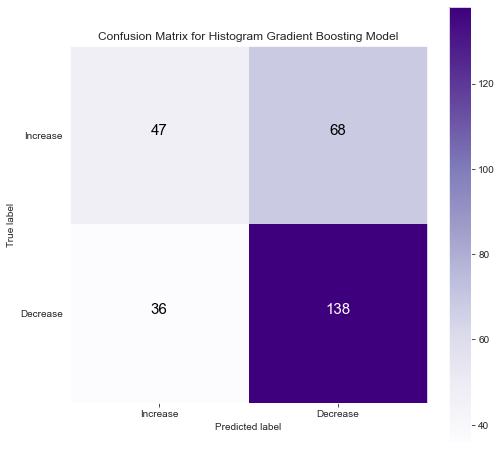

In [54]:
make_confusion_matrix(y_true=increase, y_pred=predicted_increase,classes=["Increase", "Decrease"],title="Confusion Matrix for Histogram Gradient Boosting Model", cmap=plt.cm.Purples, figsize=(8,8))

In [55]:
from helper_metrics import save_model
save_model(clf, "hgbr_crop.joblib")